In [1]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

from utils import *

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
movies = pd.read_csv("/content/MovieDataset_1990_2342.csv")
movies

,Unnamed: 0,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,year,filename
0,0,1450330,http://www.imdb.com/title/tt1450330,Roadie (2011),6.0,Comedy|Drama|Music,https://images-na.ssl-images-amazon.com/images...,2011,1450330.jpg
1,1,1018830,http://www.imdb.com/title/tt1018830,Yonkers Joe (2008),6.5,Drama,https://images-na.ssl-images-amazon.com/images...,2008,1018830.jpg
2,2,964185,http://www.imdb.com/title/tt964185,Tetro (2009),6.9,Drama,https://images-na.ssl-images-amazon.com/images...,2009,964185.jpg
3,3,2245906,http://www.imdb.com/title/tt2245906,Tini nezabutykh predkiv. Tayemnytsi molfara (2...,6.3,Adventure|Fantasy|Mystery,https://images-na.ssl-images-amazon.com/images...,2013,2245906.jpg
4,4,1727381,http://www.imdb.com/title/tt1727381,The Trouble with the Truth (2011),5.9,Drama,https://images-na.ssl-images-amazon.com/images...,2011,1727381.jpg
...,...,...,...,...,...,...,...,...,...
2337,2340,374279,http://www.imdb.com/title/tt374279,Sof Ha'Olam Smola (2004),7.0,Drama|Romance,https://images-na.ssl-images-amazon.com/images...,2004,374279.jpg
2338,2341,317910,http://www.imdb.com/title/tt317910,The Fog of War: Eleven Lessons from the Life o...,8.2,Documentary|Biography|History,https://images-na.ssl-images-amazon.com/images...,2003,317910.jpg
2339,2342,2306783,http://www.imdb.com/title/tt2306783,The Falls (2012),6.4,Drama|Romance,https://images-na.ssl-images-amazon.com/images...,2012,2306783.jpg
2340,2343,1157549,http://www.imdb.com/title/tt1157549,Cea mai fericitÌ£ fatÌ£ din lume (2009),7.0,Comedy|Drama,https://images-na.ssl-images-amazon.com/images...,2009,1157549.jpg


In [3]:
movies.dropna(subset=['imdbId', 'Genre', 'Poster'], inplace=True)
movies.drop(movies[movies['Genre'].str.contains('Adult')].index, inplace=True)

movies

,Unnamed: 0,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,year,filename
0,0,1450330,http://www.imdb.com/title/tt1450330,Roadie (2011),6.0,Comedy|Drama|Music,https://images-na.ssl-images-amazon.com/images...,2011,1450330.jpg
1,1,1018830,http://www.imdb.com/title/tt1018830,Yonkers Joe (2008),6.5,Drama,https://images-na.ssl-images-amazon.com/images...,2008,1018830.jpg
2,2,964185,http://www.imdb.com/title/tt964185,Tetro (2009),6.9,Drama,https://images-na.ssl-images-amazon.com/images...,2009,964185.jpg
3,3,2245906,http://www.imdb.com/title/tt2245906,Tini nezabutykh predkiv. Tayemnytsi molfara (2...,6.3,Adventure|Fantasy|Mystery,https://images-na.ssl-images-amazon.com/images...,2013,2245906.jpg
4,4,1727381,http://www.imdb.com/title/tt1727381,The Trouble with the Truth (2011),5.9,Drama,https://images-na.ssl-images-amazon.com/images...,2011,1727381.jpg
...,...,...,...,...,...,...,...,...,...
2337,2340,374279,http://www.imdb.com/title/tt374279,Sof Ha'Olam Smola (2004),7.0,Drama|Romance,https://images-na.ssl-images-amazon.com/images...,2004,374279.jpg
2338,2341,317910,http://www.imdb.com/title/tt317910,The Fog of War: Eleven Lessons from the Life o...,8.2,Documentary|Biography|History,https://images-na.ssl-images-amazon.com/images...,2003,317910.jpg
2339,2342,2306783,http://www.imdb.com/title/tt2306783,The Falls (2012),6.4,Drama|Romance,https://images-na.ssl-images-amazon.com/images...,2012,2306783.jpg
2340,2343,1157549,http://www.imdb.com/title/tt1157549,Cea mai fericitÌ£ fatÌ£ din lume (2009),7.0,Comedy|Drama,https://images-na.ssl-images-amazon.com/images...,2009,1157549.jpg


In [4]:
movies['imdbId'] = movies['imdbId'].astype('int')

In [5]:
movies['imdbId']

0       1450330
1       1018830
2        964185
3       2245906
4       1727381
         ...   
2337     374279
2338     317910
2339    2306783
2340    1157549
2341    2042568
Name: imdbId, Length: 2342, dtype: int64

In [6]:
movies['imdbId'] = movies['imdbId'].astype('str')

In [7]:
movies.imdbId

0       1450330
1       1018830
2        964185
3       2245906
4       1727381
         ...   
2337     374279
2338     317910
2339    2306783
2340    1157549
2341    2042568
Name: imdbId, Length: 2342, dtype: object

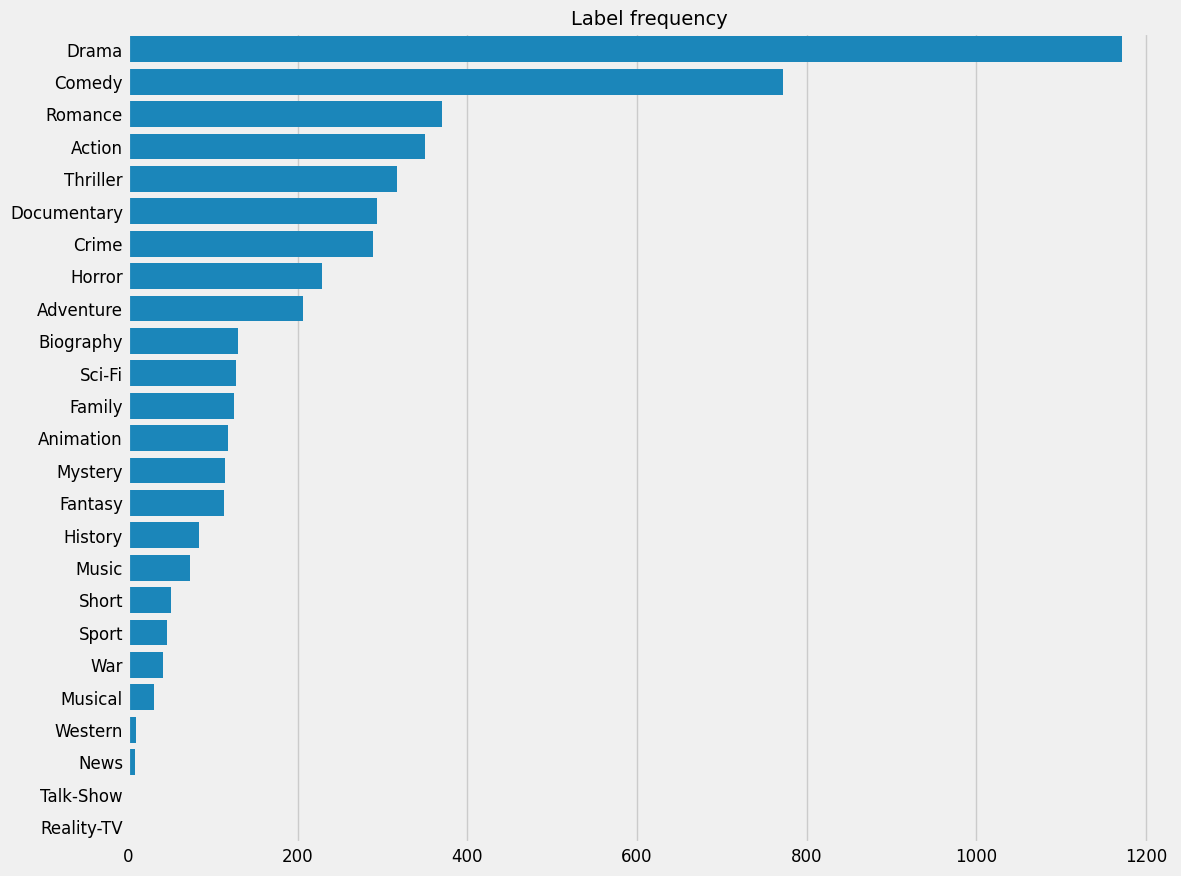

In [8]:
# Get label frequencies in descending order
label_freq = movies['Genre'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [9]:
rare = list(label_freq[label_freq<100].index)
rare

['History',
 'Music',
 'Short',
 'Sport',
 'War',
 'Musical',
 'Western',
 'News',
 'Talk-Show',
 'Reality-TV']

In [10]:
unique = list(label_freq[label_freq>100].index)
unique

['Drama',
 'Comedy',
 'Romance',
 'Action',
 'Thriller',
 'Documentary',
 'Crime',
 'Horror',
 'Adventure',
 'Biography',
 'Sci-Fi',
 'Family',
 'Animation',
 'Mystery',
 'Fantasy']

In [11]:
movies.Genre = movies.Genre.apply(lambda s: [l for l in str(s).split('|') if l not in rare])

In [12]:
movies.Genre

0                     [Comedy, Drama]
1                             [Drama]
2                             [Drama]
3       [Adventure, Fantasy, Mystery]
4                             [Drama]
                    ...              
2337                 [Drama, Romance]
2338         [Documentary, Biography]
2339                 [Drama, Romance]
2340                  [Comedy, Drama]
2341                          [Drama]
Name: Genre, Length: 2342, dtype: object

In [13]:
X_train, X_val, y_train, y_val = train_test_split(movies['imdbId'], movies['Genre'], test_size=0.2, random_state=1337)

In [14]:
len(X_train)

1873

In [15]:
len(X_val)

469

In [16]:
X_train[:5]

2089    2261749
1074    4483220
1477     295578
2300    2617828
1358     352248
Name: imdbId, dtype: object

In [17]:
data_test_1 = list(X_train) + list(X_val)
data_test_1

['2261749',
 '4483220',
 '295578',
 '2617828',
 '352248',
 '4067162',
 '384037',
 '3405714',
 '4072352',
 '1027747',
 '2189418',
 '3682556',
 '111590',
 '193763',
 '2327453',
 '1543883',
 '329767',
 '293715',
 '3165630',
 '2265050',
 '100963',
 '481222',
 '3243196',
 '293199',
 '2309987',
 '119594',
 '1068958',
 '1216487',
 '5070196',
 '114594',
 '1279185',
 '923683',
 '2094018',
 '1705786',
 '2054790',
 '116932',
 '2377396',
 '814075',
 '3880688',
 '2650986',
 '444628',
 '2325719',
 '388482',
 '964185',
 '1172061',
 '3157686',
 '2442080',
 '1292643',
 '1937390',
 '1144797',
 '3319518',
 '1905010',
 '5090828',
 '968264',
 '115683',
 '3966942',
 '3577624',
 '3169706',
 '113114',
 '1912996',
 '779982',
 '119506',
 '192614',
 '1641841',
 '383551',
 '129358',
 '2131674',
 '473308',
 '400868',
 '3826814',
 '3368222',
 '1103273',
 '976216',
 '1773314',
 '3785740',
 '905361',
 '903627',
 '452634',
 '119004',
 '1059836',
 '448120',
 '1822302',
 '119194',
 '1302559',
 '279083',
 '170452',
 '162

In [18]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [19]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/2k_photo_data.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [20]:
X_train = [os.path.join('/tmp/2k_photo_data', str(f)+'.jpg') for f in X_train]
X_val = [os.path.join('/tmp/2k_photo_data', str(f)+'.jpg') for f in X_val]

In [21]:
X_train[:5]

['/tmp/2k_photo_data/2261749.jpg',
 '/tmp/2k_photo_data/4483220.jpg',
 '/tmp/2k_photo_data/295578.jpg',
 '/tmp/2k_photo_data/2617828.jpg',
 '/tmp/2k_photo_data/352248.jpg']

In [22]:
import os

count = 0
for file in X_train:
  if os.path.isfile(file) == False:
    count += 1
    print(file)

print(count)

0


In [23]:
y_train

2089                       [Comedy]
1074               [Comedy, Horror]
1477                [Crime, Action]
2300               [Drama, Romance]
1358             [Biography, Drama]
                   ...             
1906      [Comedy, Fantasy, Horror]
1497                      [Romance]
1256               [Drama, Fantasy]
860                      [Thriller]
189     [Action, Adventure, Horror]
Name: Genre, Length: 1873, dtype: object

In [24]:
y_train = list(y_train)

In [25]:
y_val = list(y_val)

In [26]:
y_train

[['Comedy'],
 ['Comedy', 'Horror'],
 ['Crime', 'Action'],
 ['Drama', 'Romance'],
 ['Biography', 'Drama'],
 ['Documentary', 'Drama'],
 ['Comedy', 'Romance'],
 ['Action', 'Adventure', 'Fantasy'],
 ['Drama'],
 ['Action', 'Crime', 'Drama'],
 ['Adventure', 'Comedy', 'Fantasy'],
 ['Animation', 'Comedy'],
 ['Comedy', 'Drama', 'Romance'],
 ['Action', 'Crime', 'Horror'],
 ['Drama'],
 ['Documentary'],
 ['Comedy', 'Drama', 'Romance'],
 ['Comedy', 'Drama', 'Romance'],
 ['Drama'],
 ['Comedy'],
 ['Action', 'Comedy', 'Drama'],
 ['Documentary'],
 ['Action', 'Adventure', 'Crime'],
 ['Action', 'Drama'],
 ['Drama', 'Thriller'],
 ['Crime', 'Drama', 'Mystery'],
 ['Action', 'Comedy', 'Horror'],
 ['Crime', 'Drama', 'Mystery'],
 ['Comedy', 'Family', 'Romance'],
 ['Comedy', 'Crime'],
 ['Drama', 'Romance'],
 ['Horror'],
 ['Drama', 'Thriller'],
 ['Comedy', 'Drama'],
 ['Drama'],
 ['Comedy', 'Drama', 'Romance'],
 ['Comedy', 'Drama'],
 ['Documentary', 'Crime'],
 [],
 ['Action', 'Crime', 'Drama'],
 ['Action', 'Comed

In [27]:
y_data = y_train + y_val
X_data = X_train + X_val

In [48]:
data_test_1[1]
(movies.index[movies.imdbId == data_test_1[1]].to_list())[0]

1074

In [42]:
movies.imdbId[1074]

'4483220'

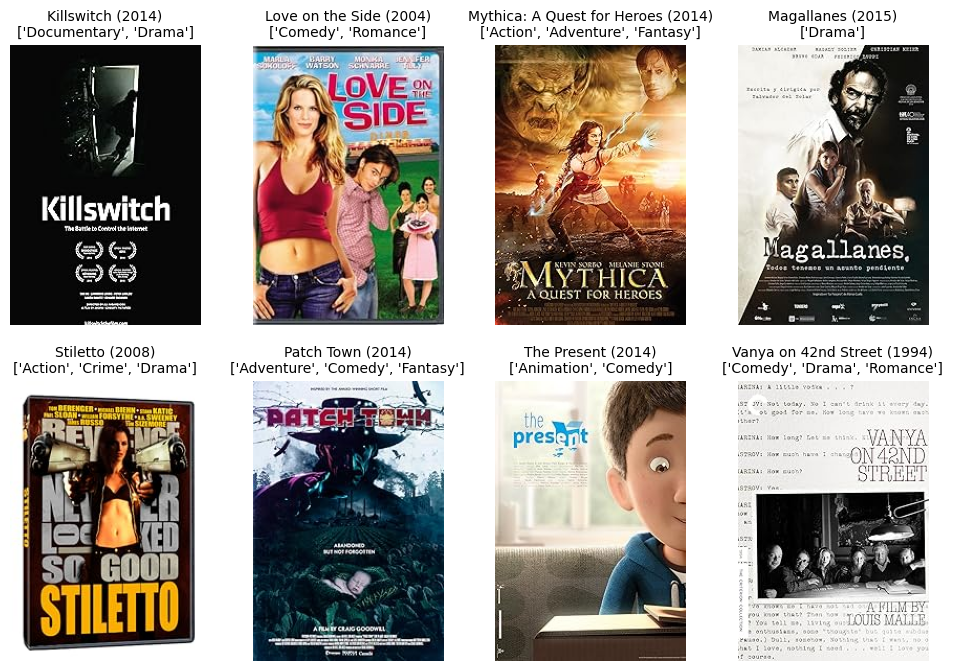

In [57]:
import os
import matplotlib.pyplot as plt
from matplotlib import style
from PIL import Image

nobs = 8
ncols = 4
nrows = nobs // ncols

style.use("default")
plt.figure(figsize=(12, 4 * nrows))
for i in range(nrows * ncols):
    ax = plt.subplot(nrows, ncols, i + 1)
    if os.path.isfile(X_train[i+5]) == True:
        plt.imshow(Image.open(X_train[i+5]))
        plt.title(f'{movies.Title[(movies.index[movies.imdbId == data_test_1[i+5]].to_list())[0]]}\n{y_train[i+5]}', size=10)
        plt.axis('off')
    else:
        pass

plt.savefig('output_figure.png')
plt.show()


In [ ]:
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)
# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

In [ ]:
mlb.classes_.itemsize

In [ ]:
y_train_bin = mlb.transform(y_train)
y_train_bin

In [ ]:
y_val_bin = mlb.transform(y_val)
y_val_bin

In [ ]:
print(y_train_bin[5],
      y_val_bin[5])

In [ ]:
IMG_SIZE = 224
CHANNELS = 3

In [ ]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [ ]:
BATCH_SIZE = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1024

In [ ]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

In [ ]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [ ]:
#MobileNetv2 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4

feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))


In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

In [ ]:
model.summary()

In [ ]:
@tf.function
def macro_soft_f1(y, y_hat):
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1
    macro_cost = tf.reduce_mean(cost)
    return macro_cost

In [ ]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [ ]:
LR = 1e-4
EPOCHS = 60

In [ ]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=macro_soft_f1,
               metrics=[macro_f1])

In [ ]:
t1 = time()

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=create_dataset(X_val, y_val_bin))

print(f'traing in {(time()-t1)}s')

In [ ]:
model_losses, model_val_losses, model_macro_f1s, model_val_macro_f1s = learning_curves(history)

In [ ]:
model_val_losses[-1]

In [ ]:
model_val_macro_f1s[-1]

In [ ]:
def show_prediction(title, movies_df, model):

    # Get movie info
    imdbId = movies.loc[movies['Title']==title]['imdbId'].iloc[0]
    genre = movies.loc[movies['Title']==title]['Genre'].iloc[0]
    img_path = os.path.join('/tmp/2k_photo_data', str(imdbId)+'.jpg')

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n\n{}\n\nGenre\n{}\n\nPrediction\n{}\n'.format(title, genre, list(prediction)), fontsize=9)
    plt.savefig(f'{title}.png')
    plt.show()

titles = ["Kung Fu Panda (2008)",
          "Mission: Impossible II (2000)",
          "The Amazing Spider-Man (2012)"]

for t in titles:
  if t in movies['Title'].values:
    show_prediction(t, movies, model)

#TB Visualize

In [ ]:
import os
import tensorflow as tf
from tensorboard.plugins import projector
from PIL import Image

In [ ]:
embeddings = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=model.layers[-2].output
)

In [ ]:
def get_img(img_path):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [224,224])
  img = tf.cast(img, tf.float32) / 255.0
  return img

images_pil = []
images_embeddings = []
labels = []

for x in range(len(X_data)):
    img_path = X_data[x]
    img_tf = get_img(img_path)
    img_tf = tf.image.resize_with_pad(img_tf, 224, 224)

    img_pil = Image.open(img_path).resize((224, 224))
    img_embedding = embeddings(tf.expand_dims(img_tf, axis=0))
    images_embeddings.append(img_embedding.numpy()[0])
    images_pil.append(img_pil)

    label = y_data[x]
    labels.append(label)

In [ ]:
import csv
import os

log_dir = '/logs/'

os.makedirs(log_dir, exist_ok=True)

tensor_file_path = os.path.join(log_dir, 'tensor.tsv')


with open(tensor_file_path, 'w', newline='') as fw:
    csv_writer = csv.writer(fw, delimiter='\t')
    csv_writer.writerows(images_embeddings)


In [ ]:
import numpy as np
from PIL import Image

one_square_size = int(np.ceil(np.sqrt(len(images_embeddings))))
master_width = 100 * one_square_size
master_height = 100 * one_square_size

spriteimage = Image.new(
    mode='RGBA',
    size=(master_width, master_height),
    color=(0, 0, 0, 0))

resize_width = 100
resize_height = 100


for count, image in enumerate(images_pil):
    div, mod = divmod(count, one_square_size)
    h_loc = 100 * div
    w_loc = 100 * mod

    resized_image = image.resize((resize_width, resize_height))

    spriteimage.paste(resized_image, (w_loc, h_loc))

spriteimage.convert('RGB').save(f'{log_dir}sprite.jpg', transparency=0)


In [ ]:
import pandas as pd
import os
import csv


data_to_save = []
data_to_save.append(["Title", "Genre"])

for id in data_test_1:
    title = movies.loc[movies['imdbId'] == id]['Title'].iloc[0]
    genre = movies.loc[movies['imdbId'] == id]['Genre'].iloc[0]

    genre = str(genre).replace("[", "").replace("]", "")

    data_to_save.append([title, genre])

metadata_file_path = os.path.join(log_dir, 'metadata.tsv')

with open(metadata_file_path, 'w', newline='', encoding='utf-8') as fw:
    csv_writer = csv.writer(fw, delimiter='\t')
    csv_writer.writerows(data_to_save)